## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model


In [2]:


BASE_DIR = 'Dataset'
WORKING_DIR = 'working'

# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

# Extract features from images
features = {}
images_dir = 'Dataset/Images'

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
for img_name in tqdm(os.listdir(images_dir)):
    # Load the image from file
    img_path = f'{images_dir}/{img_name}'
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature

# Save extracted features to a pickle file
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)


  0%|          | 0/8091 [00:00<?, ?it/s]

In [64]:

# Load features from pickle file
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
 

In [65]:
   
# create mapping of image to captions
mapping = {}
captions_file = "Dataset/Captions.txt"
with open(captions_file, 'r') as f:
    next(f)  # Skip header if any
    captions_doc = f.read()
    
    

In [66]:

# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [67]:
sorted_data = sorted(mapping.items(), key=lambda x: x[1], reverse=True)

# Get the top 3 values
top_3_values = sorted_data[:3]

print(top_3_values)

[('496606439_9333831e73', ['woman smile and wave to the camera', 'A woman in a red shirt is waving while standing behind another woman with black hair .', 'A woman in pink is staring while a woman is red is posing nearby kitchen items .', 'Two women are smiling together at a restaurant .', 'Two women in front of boxes of tea and cups .']), ('3525841965_7814484515', ['two young children standing outside on a dirt road .', 'Two smiling girls stand on a dirt road in India .', '"Two young   dark skinned girls are smiling and laughing ."', 'Two young girls are smiling at the camera .', 'Two young girls stand in the dirt road and smile at the camera .']), ('537359971_6e28f5e66e', ['two woman wearing skirts walking down the street together', 'Two women in skirts walking across a street .', 'Two women ion skirts walk across a parking lot .', '"Two women   wearing skirts and carrying purses   cross street in urban area ."', 'Two women with purses walk in an urban location .'])]


In [68]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)


# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [69]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0
                
# encoder model
# image feature layers


max_length = max(len(caption.split()) for caption in all_captions)
max_length


inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)



# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:


# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size


for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# save the model

model.save('best_model1.keras')



227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 979ms/step - loss: 2.2764
227/227 ━━━━━━━━━━━━━━━━━━━━ 225s 992ms/step - loss: 2.2425
227/227 ━━━━━━━━━━━━━━━━━━━━ 222s 978ms/step - loss: 2.2085
227/227 ━━━━━━━━━━━━━━━━━━━━ 222s 978ms/step - loss: 2.1778
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 984ms/step - loss: 2.1500
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 988ms/step - loss: 2.1237
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 984ms/step - loss: 2.0997
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 981ms/step - loss: 2.0773
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 981ms/step - loss: 2.0553
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 984ms/step - loss: 2.0315
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 986ms/step - loss: 2.0145
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 983ms/step - loss: 1.9978
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 986ms/step - loss: 1.9784
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 986ms/step - loss: 1.9649
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 989ms/step - loss: 1.9432
227/227 ━━━━━━━━━━━━━━━━━━━━ 225s 989ms/step - loss: 1.9292
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 983ms/

In [70]:
model = load_model("best_model1.keras")


In [71]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [99]:

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


In [105]:

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    


# Save actual and predicted lists to a pickle file
with open('output.pkl', 'wb') as f:
    pickle.dump((actual, predicted), f)



  0%|          | 0/810 [00:00<?, ?it/s]

In [75]:

from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    


---------------------Actual---------------------
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
--------------------Predicted--------------------
startseq truck hangs off rocky truck endseq


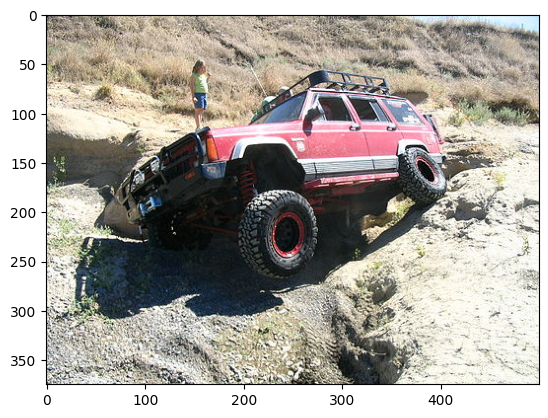

In [43]:
generate_caption("36422830_55c844bc2d.jpg")

---------------------Actual---------------------
startseq group of people in protective gear endseq
startseq man looking down wearing racing clothes with motorcycle to the right endseq
startseq man stands outside endseq
startseq "a man wearing dirt bike clothes with logo in close-up ." endseq
startseq person in bike riding gear standing with mountains in the background endseq
--------------------Predicted--------------------
startseq two people work on an outdoor outdoor outdoor table endseq


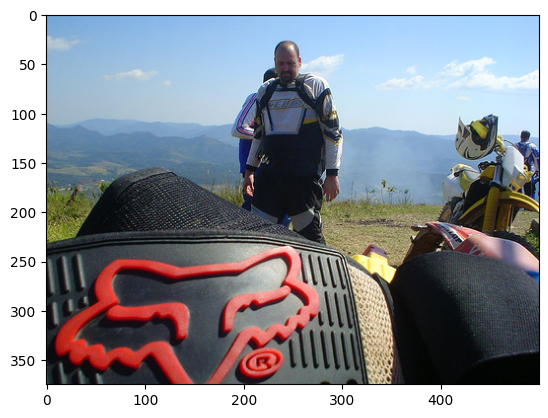

In [46]:
generate_caption("207930963_af3a2f1784.jpg")

In [78]:
generate_caption("36422830_55c844bc2d.jpg")

---------------------Actual---------------------
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
--------------------Predicted--------------------
startseq truck hangs off rocky truck endseq


In [68]:

vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
#using real images
image_path = "1655430860333.jpeg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq small dog runs through the green grass endseq'

In [115]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras.models import Model

# Initialize tkinter
root = tk.Tk()
root.title("Image Captioning")

# Load the pre-trained VGG model
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)


# Load features from pickle file
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

# Function to handle button click
def generate_caption():
    # Load the image
    file_path = filedialog.askopenfilename()
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    # Extract features
    feature = vgg_model.predict(image, verbose=0)
    
    # Predict caption using the existing predict_caption function
    caption = predict_caption(model, feature, tokenizer, max_length=35)
    
    # Update label with caption
    result_label.config(text="Caption: " + caption)
    
    # Display image
    img = Image.open(file_path)
    img = img.resize((200, 200), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    image_label.config(image=img)
    image_label.image = img

# Create a button to choose image
browse_button = tk.Button(root, text="Browse Image", command=generate_caption)
browse_button.pack(pady=10)

# Label to display image
image_label = tk.Label(root)
image_label.pack(pady=10)

# Label to display result
result_label = tk.Label(root, text="")
result_label.pack(pady=10)

# Run the tkinter event loop
root.mainloop()


C:\Users\Muneeb\AppData\Local\Temp\ipykernel_5676\3250014305.py:42: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((200, 200), Image.ANTIALIAS)
